<a href="https://colab.research.google.com/github/Dario-Caf/EM-shower-simulator-with-NN/blob/main/notebook%20and%20slides/Debug_and_train_cGAN_versione_ok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial configuration
=====================

In [1]:
!nvidia-smi -L
!lscpu |grep 'Model name'

GPU 0: Tesla K80 (UUID: GPU-5cd82b9f-5935-4381-4245-6898f03284fa)
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


In [2]:
!git clone -b daniele https://github.com/Dario-Caf/EM-shower-simulator-with-NN
!pip install -r EM-shower-simulator-with-NN/requirements.txt

Cloning into 'EM-shower-simulator-with-NN'...
remote: Enumerating objects: 2770, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 2770 (delta 24), reused 64 (delta 19), pack-reused 2698
Receiving objects: 100% (2770/2770), 882.67 MiB | 19.73 MiB/s, done.
Resolving deltas: 100% (1419/1419), done.
Checking out files: 100% (181/181), done.
     |████████████████████████████████| 298 kB 11.1 MB/s 
     |████████████████████████████████| 14.5 MB 37.1 MB/s 
     |████████████████████████████████| 462 kB 41.9 MB/s 


In [3]:
%cd EM-shower-simulator-with-NN
%cd EM_shower_simulator

/content/EM-shower-simulator-with-NN
/content/EM-shower-simulator-with-NN/EM_shower_simulator


In [ ]:
%run train.py

In [ ]:
%run debug.py

In [ ]:
%run shower_simulator.py

Imports and costants
====================

In [4]:
VERBOSE = True

In [5]:
import os
import sys
import time
import logging
from pathlib import Path

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras import Model
from tensorflow.keras.utils import Progbar
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.train import CheckpointManager as Manager
from tensorflow.keras.layers import (Input,
                                     Concatenate,
                                     Embedding,
                                     Dense,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Reshape,
                                     Conv3DTranspose,
                                     MaxPooling3D,
                                     AveragePooling3D,
                                     Conv3D,
                                     Dropout,
                                     Lambda,
                                     ELU,
                                     Flatten)

from IPython import display

from constants import default_list

# Train import
from dataset import logData, data_pull, debug_data_pull, debug_shower

from unbiased_metrics import shower_depth_lateral_width

#-------------------------------------------------------------------------------
"""Constant parameters of configuration and definition of global objects."""

# Configuration parameters
N_PID = 3
N_ENER = 30 + 1
NOISE_DIM = 1024
MBSTD_GROUP_SIZE = 8                                     #minibatch dimension
ENERGY_NORM = 6.7404
ENERGY_SCALE = 1000000.
GEOMETRY = (12, 25, 25, 1)
PARAM_EN = 0.01

# Define logger and handler
logMod = logging.getLogger("ModelsLogger")

# Create a random seed, to be used during the evaluation of the cGAN.
tf.random.set_seed(15)
num_examples = 8
test_noise = [tf.random.normal([num_examples, NOISE_DIM]),
              tf.random.uniform([num_examples, 1], minval= 0., maxval=N_ENER),
              tf.random.uniform([num_examples, 1], minval= 0., maxval=N_PID)]

# Define logger
logGAN = logging.getLogger("CGANLogger")

#-------------------------------------------------------------------------------

# Path list from this folder
path_list = [os.path.join('..', path) for path in default_list]


# Examples to show
EXAMPLES = 8

# Define logger and handler
ch = logging.StreamHandler()
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logger = logging.getLogger("DEBUGLogger")
logger.addHandler(ch)
logData.addHandler(ch)
logMod.addHandler(ch)
logGAN.addHandler(ch)

Make models: _C type
====================

In [6]:
"""Subroutins for the creation of the generator and discriminator models."""

"""General subroutines for the network."""

def compute_energy(in_images):
    """Compute energy deposited in detector."""
    in_images = tf.cast(in_images, tf.float32)
    en_images = tf.math.multiply(in_images, ENERGY_NORM)
    en_images = tf.math.pow(10., en_images)
    en_images = tf.math.divide(en_images, ENERGY_SCALE)
    en_images = tf.math.reduce_sum(en_images, axis=[1,2,3])
    return en_images

def energies_per_layer(in_images):
    """Compute energy deposited in detector for each layer, then it appends to
    input images per each layer.
    """
    in_images = tf.cast(in_images, tf.float32)
    shape = in_images.shape

    en_images = tf.math.multiply(in_images, ENERGY_NORM)
    en_images = tf.math.pow(10., en_images)
    en_images = tf.math.divide(en_images, ENERGY_SCALE)
    en_images = tf.math.reduce_sum(en_images, axis=[2,3,4], keepdims=True)

    en_images = tf.tile(en_images, [1, 1 , shape[2], shape[3], 1])
    en_images = tf.concat([in_images, en_images], axis=-1)
    #output: (None, 12,25,25,1)
    return  en_images

def minibatch_stddev_layer(discr, group_size=MBSTD_GROUP_SIZE):
    """Minibatch discrimination layer is important to avoid mode collapse.
    Once it is wrapped with a Lambda Keras layer it returns an additional filter
    node with information about the statistical distribution of the group_size,
    allowing the discriminator to recognize when the generator strarts to
    replicate the same kind of event multiple times.

    Inspired by
    https://github.com/tkarras/progressive_growing_of_gans/blob/master/networks.py
    """
    with tf.compat.v1.variable_scope('MinibatchStddev'):
        # Input 0 dimension must be divisible by (or smaller than) group_size.
        group_size = tf.minimum(group_size, tf.shape(discr)[0])
        # Input shape.
        shape = discr.shape
        # Split minibatch into M groups of size G.
        minib = tf.reshape(discr, [group_size, -1, shape[1], shape[2], shape[3], shape[4]])
        # Cast to FP32.
        minib = tf.cast(minib, tf.float32)
        # Calculate the std deviation for each pixel over minibatch
        minib = tf.math.reduce_std(minib + 1E-6, axis=0)
        # Take average over fmaps and pixels.
        minib = tf.reduce_mean(minib, axis=[2,3,4], keepdims=True)
        # Cast back to original data type.
        minib = tf.cast(minib, discr.dtype)
        # New tensor by replicating input multiples times.
        minib = tf.tile(minib, [group_size, 1 , shape[2], shape[3], 1])
        # Append as new fmap.
        return tf.concat([discr, minib], axis=-1)

#-------------------------------------------------------------------------------

"""Subroutines for the generator network."""

"""Generator model."""

def make_generator_model():
    """Define generator model:
    Input 1) Random noise from which the network creates a vector of images;
    Input 2) Energy label to be passed to the network;
    Input 3) ParticleID label to be passed to the network.

    Labels are given as scalars in input; then they are passed to an embedding
    layer that creates a sort of lookup-table (vector[EMBED_DIM] of floats) that
    categorizes the labels in N_CLASSES * classes.
    """
    BASE = 8
    FILTER = 32
    EMBED_DIM = 30
    KERNEL_L = (1, 8, 8)
    KERNEL_S = (3, 6, 6)
    n_nodes = BASE*BASE*BASE
    image_shape = (BASE, BASE, BASE, -1)

    # Input[i] -> input[i] + convolution * (KERNEL-1)
    error = "ERROR building the generator: shape different from geometry!"

    # Image generator input
    in_lat = Input(shape=(NOISE_DIM,), name="latent_input")
    li_lat = Reshape(image_shape)(in_lat)

    # Energy label input
    en_label = Input(shape=(1,), name="energy_input")
    li_en = Dense(n_nodes, activation="relu")(en_label)
    li_en = Dense(n_nodes, activation="relu")(li_en)
    li_en = Reshape(image_shape)(li_en)

    # ParticleID label input
    pid_label = Input(shape=(1,), name="particle_input")
    li_pid = Embedding(N_PID, EMBED_DIM)(pid_label)
    li_pid = Dense(n_nodes, activation="relu")(li_pid)
    li_pid = Reshape(image_shape)(li_pid)

    # Combine noise and particle ID
    gen = Concatenate()([li_lat, li_pid])
    logMod.info(gen.get_shape())

    gen = Conv3DTranspose(1, KERNEL_S, padding="same", activation="relu")(gen)
    logMod.info(gen.get_shape())

    # Combine image and energy
    gen = Concatenate()([gen, li_en])
    logMod.info(gen.get_shape())

    gen = Dense(FILTER, activation="relu")(gen)
    gen = Dense(2*FILTER, activation="relu")(gen)

    gen = Conv3DTranspose(2*FILTER, KERNEL_L)(gen)
    logMod.info(gen.get_shape())
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    gen = Conv3DTranspose(FILTER, KERNEL_S)(gen)
    logMod.info(gen.get_shape())
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    output = Conv3DTranspose(1, KERNEL_S, activation="tanh", name="image")(gen)

    logMod.info(f"Shape of the generator output: {output.get_shape()}")
    assert output.get_shape().as_list()==[None, *GEOMETRY], error

    model = Model([in_lat, en_label, pid_label], output, name='generator')
    return model

def make_generator_model_old():
    """Define generator model:
    Input 1) Random noise from which the network creates a vector of images;
    Input 2) Energy label to be passed to the network;
    Input 3) ParticleID label to be passed to the network.

    Labels are given as scalars in input; then they are passed to an embedding
    layer that creates a sort of lookup-table (vector[EMBED_DIM] of floats) that
    categorizes the labels in N_CLASSES * classes.
    """
    BASE = 8
    FILTER = 32
    EMBED_DIM = 30
    KERNEL_L = (1, 8, 8)
    KERNEL_S = (3, 6, 6)
    n_nodes = BASE*BASE*BASE
    image_shape = (BASE, BASE, BASE, -1)

    # Input[i] -> input[i] + convolution * (KERNEL-1)
    error = "ERROR building the generator: shape different from geometry!"

    # Image generator input
    in_lat = Input(shape=(NOISE_DIM,), name="latent_input")
    li_lat = Reshape(image_shape)(in_lat)

    # Energy label input
    en_label = Input(shape=(1,), name="energy_input")
    li_en = Dense(n_nodes, activation="relu")(en_label)
    li_en = Dense(n_nodes, activation="relu")(li_en)
    li_en = Reshape(image_shape)(li_en)

    # ParticleID label input
    pid_label = Input(shape=(1,), name="particle_input")
    li_pid = Embedding(N_PID, EMBED_DIM)(pid_label)
    li_pid = Dense(n_nodes, activation="relu")(li_pid)
    li_pid = Reshape(image_shape)(li_pid)

    # Combine noise and particle ID
    gen = Concatenate()([li_lat, li_pid])
    logMod.info(gen.get_shape())

    gen = Conv3DTranspose(3, KERNEL_S, padding="same", use_bias=False)(gen)
    logMod.info(gen.get_shape())

    # Combine image and energy
    gen = Concatenate()([gen, li_en])
    logMod.info(gen.get_shape())

    gen = Dense(FILTER, activation="relu", use_bias=False)(gen)
    gen = Dense(FILTER, activation="relu", use_bias=False)(gen)

    gen = Conv3DTranspose(2*FILTER, KERNEL_L, use_bias=False)(gen)
    logMod.info(gen.get_shape())
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    gen = Conv3DTranspose(FILTER, KERNEL_S, use_bias=False)(gen)
    logMod.info(gen.get_shape())
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    output = Conv3DTranspose(1, KERNEL_S, activation="tanh", name="image")(gen)

    logMod.info(f"Shape of the generator output: {output.get_shape()}")
    assert output.get_shape().as_list()==[None, *GEOMETRY], error

    model = Model([in_lat, en_label, pid_label], output, name='generator')
    return model

#-------------------------------------------------------------------------------
"""Discriminator model."""

def make_discriminator_model():
    """Define discriminator model:
    Input 1) Vector of images associated to the given labels;
    Input 2) Energy label to be passed to the network;
    Input 3) ParticleID label to be passed to the network.

    Labels are given as scalars in input; then they are passed to an embedding
    layer that creates a sort of lookup-table (vector[EMBED_DIM] of floats) that
    categorizes the labels in N_CLASSES * classes.
    """
    N_FILTER = 32
    KERNEL = (3, 6, 6)

    # padding="same" add a 0 to borders, "valid" use only available data !
    # Output of convolution = (input + 2padding - kernel) / strides + 1 !
    # Here we use padding default = "valid" (=0 above) and strides = 1 !
    # GEOMETRY[i] -> GEOMETRY[i] - n_convolution * (KERNEL[i] - 1) > 0 !
    error = "ERROR building the discriminator: smaller KERNEL is required!"

    # Image input
    in_image = Input(shape=GEOMETRY, name="input_image")
    in_image_en_layer = Lambda(energies_per_layer, name="input_image_energy_per_layer")(in_image)

    discr = Conv3D(N_FILTER, (1,6,6) )(in_image_en_layer)
    logMod.info(discr.get_shape())
    discr = LeakyReLU(alpha=0.2)(discr)
    discr = Dropout(0.3)(discr)

    discr = AveragePooling3D(pool_size=(2,2,2), padding="valid")(discr)

    minibatch = Lambda(minibatch_stddev_layer, name="minibatch")(discr)
    logMod.info(f"Minibatch shape: {discr.get_shape()}")

    discr = Conv3D(N_FILTER, KERNEL)(minibatch)
    logMod.info(discr.get_shape())
    discr = LeakyReLU(alpha=0.2)(discr)

    discr = MaxPooling3D(pool_size=(2,2,2), padding="valid")(discr)

    logMod.info(discr.get_shape())
    discr = Flatten()(discr)

    discr_conv = Dense(4*N_FILTER, activation="relu")(discr)
    discr_conv = Dense(2*N_FILTER, activation="relu")(discr_conv)
    output_conv = Dense(1, activation="sigmoid", name="decision")(discr_conv)

    discr_en = Dense(4*N_FILTER, activation="relu")(discr)
    discr_en = Dense(2*N_FILTER, activation="relu")(discr_en)
    output_en = Dense(1, activation="relu", name="energy_label")(discr_en)

    discr_id = Dense(4*N_FILTER, activation="relu")(discr)
    discr_id = Dense(2*N_FILTER, activation="sigmoid")(discr_id)
    output_id = Dense(1, activation="sigmoid", name="particle_label")(discr_id)

    output = [output_conv, output_en, output_id]
    model = Model(in_image, output, name='discriminator')
    return model

def make_discriminator_model_D():
    """Define discriminator model:
    Input 1) Vector of images associated to the given labels;
    Input 2) Energy label to be passed to the network;
    Input 3) ParticleID label to be passed to the network.

    Labels are given as scalars in input; then they are passed to an embedding
    layer that creates a sort of lookup-table (vector[EMBED_DIM] of floats) that
    categorizes the labels in N_CLASSES * classes.
    """
    N_FILTER = 64
    KERNEL = (5, 5, 5)
    KERNEL_1 = (3, 3, 3)
    KERNEL_2 = (2, 2, 2)
    # padding="same" add a 0 to borders, "valid" use only available data !
    # Output of convolution = (input + 2padding - kernel) / strides + 1 !
    # Here we use padding default = "valid" (=0 above) and strides = 1 !
    # GEOMETRY[i] --> GEOMETRY[i] - n*convolution*(KERNEL[i] - 1) > 0 !
    error = "ERROR building the discriminator: smaller KERNEL is required!"

    n_nodes = 1
    for cell in GEOMETRY:
        n_nodes = n_nodes * cell

    # Image input
    in_image = Input(shape=GEOMETRY, name="input_image")

    energies = Lambda(energies_per_layer, name="energies_per_layer")(in_image)
    energies = Dense(2*N_FILTER, activation="relu")(energies)

    discr = Conv3D(N_FILTER, KERNEL, use_bias=False)(in_image)#in_image
    logMod.info(discr.get_shape())
    discr = AveragePooling3D(pool_size = (2,2,2), padding ="valid")(discr)
    discr = LeakyReLU()(discr)
    discr = Dropout(0.3)(discr)

    minibatch = Lambda(minibatch_stddev_layer, name="minibatch")(discr)
    logMod.info(f"Minibatch shape: {discr.get_shape()}")

    discr = Conv3D(2*N_FILTER, (2,2,2) , padding="valid", use_bias=False)(minibatch)
    discr = MaxPooling3D(pool_size = (2,2,2) , padding ="valid")(discr)
    logMod.info(discr.get_shape())
    discr = LeakyReLU()(discr)
    discr = Dropout(0.3)(discr)

    logMod.info(discr.get_shape())
    discr = Flatten()(discr)
    discr = Concatenate()([discr, energies])

    discr_conv = Dense(N_FILTER, activation="relu")(discr)
    discr_conv = Dense(N_FILTER, activation="relu")(discr_conv)
    output_conv = Dense(1, activation="sigmoid", name="decision")(discr_conv)

    discr_en = Dense(N_FILTER, activation="relu")(discr)
    discr_en = Dense(N_FILTER, activation="relu")(discr_en)
    output_en = Dense(1, activation="relu", name="energy_label")(discr_en)

    discr_id = Dense(N_FILTER, activation="relu")(discr)
    discr_id = Dense(N_FILTER, activation="sigmoid")(discr_id)
    output_id = Dense(1, activation="sigmoid", name="one_hot")(discr_id)

    output = [output_conv, output_en, output_id]
    model = Model(in_image, output, name='discriminator')
    return model

#-------------------------------------------------------------------------------
"""Debug subroutines."""

def debug_generator(noise, verbose=False):
    """Uses the random seeds to generate fake samples and plots them."""
    if verbose :
        logMod.setLevel(logging.DEBUG)
        logMod.info('Logging level set on DEBUG.')
    else:
        logMod.setLevel(logging.WARNING)
        logMod.info('Logging level set on WARNING.')
    logMod.info("Start debugging the generator model.")

    generator = make_generator_model()
    data_images = generator(noise, training=False)
    logMod.info(f"Shape of generated images: {data_images.shape}")

    energy = compute_energy(data_images)

    k=0
    plt.figure("Generated showers", figsize=(20,10))
    num_examples = data_images.shape[0]
    for i in range(num_examples):
        print(f"{i+1})\tPrimary particle={int(noise[2][i][0])}"
             +f"\tInitial energy ={noise[1][i][0]}"
             +f"\tGenerated energy ={energy[i]}\n")
        for j in range(data_images.shape[1]):
           k=k+1
           plt.subplot(num_examples, data_images.shape[1], k)
           plt.imshow(data_images[i,j,:,:,0])
           plt.axis("off")
    plt.show()

    logMod.info("Debug of the generator model finished.")

def debug_discriminator(data, verbose=False):
    """Uses images from the sample to test discriminator model."""
    if verbose :
        logMod.setLevel(logging.DEBUG)
        logMod.info('Logging level set on DEBUG.')
    else:
        logMod.setLevel(logging.WARNING)
        logMod.info('Logging level set on WARNING.')
    logMod.info("Start debugging discriminator model.")

    discriminator = make_discriminator_model()
    decision = discriminator(data)
    logMod.info(f"\nDecision per raw:\n {decision[0]}")
    logMod.info("Debug of the discriminator model finished.")


Class CGAN:  real
=================

In [7]:
""" Conditional GAN Class and structure """

#-------------------------------------------------------------------------------

def shower_depth_width(showers_vector):
    """Compute shower mean depth and std;
       Compute shower mean lateral width among layers and std.
    """
    shape = showers_vector.shape

    layer_num= tf.constant([[x for x in range(shape[1])]])
    layer_num= tf.cast(tf.tile(layer_num, [shape[0],1] ), tf.float32)
    pixel_num= tf.constant([[[[x for x in range(-shape[2]//2+1, shape[2]//2+1)]
                            for y in range(-shape[2]//2+1, shape[2]//2+1)]
                            for l in range(shape[1]) ]])
    pixel_num= tf.cast(tf.tile(pixel_num, [shape[0],1,1,1] ), tf.float32)
    pixel_num= tf.reshape(pixel_num, shape)

    pixel_en = tf.math.multiply(showers_vector, ENERGY_NORM)
    pixel_en = tf.math.pow(10., pixel_en)
    pixel_en = tf.math.divide(pixel_en, ENERGY_SCALE)

    layers_en = tf.math.reduce_sum(pixel_en, axis=[2,3,4])
    total_en  = tf.math.reduce_sum(layers_en, axis=1)

    layers_scalar_prod_en   = tf.math.multiply(layers_en, layer_num)
    depth_weighted_total_en = tf.math.reduce_sum(layers_scalar_prod_en, axis=1)

    # shower depth
    shower_depth = tf.math.divide(depth_weighted_total_en,total_en)
    depth_mean = tf.math.reduce_mean(shower_depth, axis = 0)
    depth_std  = tf.math.reduce_std(shower_depth, axis=0)

    x = tf.math.multiply(pixel_en,pixel_num)
    x = tf.math.reduce_sum(x, axis=[2,3,4])

    x2 = tf.math.multiply(pixel_en, pixel_num**2)
    x2 = tf.math.reduce_sum(x2, axis=[2,3,4])

    # shower lateral width
    lateral_width  = tf.math.sqrt(tf.math.abs(x2/layers_en - (x/layers_en)**2))
    width_mean = tf.math.reduce_mean(lateral_width, axis=[0,1])
    width_std  = tf.math.reduce_std(lateral_width, axis=[0,1])

    metrics = [depth_mean, depth_std, width_mean, width_std]
    return metrics

#-------------------------------------------------------------------------------

class ConditionalGAN(tf.keras.Model):
    """Class for a conditional GAN.
    It inherits keras.Model properties and functions.
    """
    def __init__(self, gener, discr, learning_rate=2e-5):
        """Constructor.
        Inputs:
        gener = generator network;
        discr = discriminator network;
        learning_rate = starting poor learning rate.
        """
        super(ConditionalGAN, self).__init__()
        self.generator = gener
        self.discriminator = discr
        self.history = {}
        self.logs = {}

        # Metrics
        self.gener_loss_tracker = Mean(name="gener_loss")
        self.discr_loss_tracker = Mean(name="discr_loss")
        self.real_energ_loss_tracker = Mean(name="real_energy_loss")
        self.fake_energ_loss_tracker = Mean(name="fake_energy_loss")
        self.real_parID_loss_tracker = Mean(name="real_particle_loss")
        self.fake_parID_loss_tracker = Mean(name="fake_particle_loss")
        self.computed_e_tracker = Mean(name="fake_computed_loss")

        # Unbiased metrics
        self.mean_depth_tracker = Mean(name="mean_depth")
        self.std_depth_tracker  = Mean(name="std_depth")
        self.mean_lateral_tracker = Mean(name="mean_width")
        self.std_lateral_tracker  = Mean(name="std_width")

        # Optimizers
        self.generator_optimizer = Adam(learning_rate * 10)
        self.discriminator_optimizer = Adam(learning_rate)

        # Manager to save rusults from training in form of checkpoints
        self.checkpoint = tf.train.Checkpoint(
                           generator=self.generator,
                           discriminator=self.discriminator,
                           generator_optimizer=self.generator_optimizer,
                           discriminator_optimizer=self.discriminator_optimizer)

        self.manager = Manager(self.checkpoint, './checkpoints', max_to_keep=5)

    @property
    def metrics(self):
        """Metrics of the cGAN network."""
        return [self.gener_loss_tracker,
                self.discr_loss_tracker,
                self.real_energ_loss_tracker,
                self.fake_energ_loss_tracker,
                self.real_parID_loss_tracker,
                self.fake_parID_loss_tracker,
                self.computed_e_tracker,
                self.mean_depth_tracker,
                self.std_depth_tracker,
                self.mean_lateral_tracker,
                self.std_lateral_tracker]

    def update_metrics(self, args):
        """Update metrics and logs preventing NaN propagation."""
        for metric, arg in zip(self.metrics, args):
            key = metric.name
            if tf.math.is_nan(arg):
                 raise AssertionError(f"\nERROR IN {key}: NAN VALUE")
            metric.update_state(arg)
            self.logs[key] = metric.result().numpy()

    def compile(self):
        """Compile method of the cGAN network.
        Quite useless in this case because the training set up has been done in
        the constructor of the class. It associate to the new abstract model an
        optimizer attribute 'rmsprop', and loss, metrics=None.
        """
        super(ConditionalGAN, self).compile()

    def summary(self):
        """Summary method of the cGAN network."""
        print("\nPrinting conditional GAN summary to file.\n")
        save_path = Path('model_plot').resolve()
        if not os.path.isdir(save_path):
           os.makedirs(save_path)
        file_name = "cgan-summary.txt"
        path = os.path.join(save_path, file_name)
        with open(path, 'w') as file:
           file.write('\nConditional GAN summary\n\n')
           self.generator.summary(print_fn=lambda x: file.write(x + '\n'))
           file.write('\n\n')
           self.discriminator.summary(print_fn=lambda x: file.write(x + '\n'))
           file.write('\n\n')

    def plot_model(self):
        """Plot_model method of the cGAN network."""
        print("\nPlotting and saving conditional GAN scheme.\n")
        save_path = Path('model_plot').resolve()
        if not os.path.isdir(save_path):
           os.makedirs(save_path)

        fig = plt.figure("Model scheme", figsize=(20,10))
        plt.subplot(1, 2, 1)
        plt.title("Generator")
        file_name = "cgan-generator.png"
        path = os.path.join(save_path, file_name)
        plot_model(self.generator, to_file=path, show_shapes=True)
        plt.imshow(imread(path))
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.title("Discriminator")
        file_name = "cgan-discriminator.png"
        path = os.path.join(save_path, file_name)
        plot_model(self.discriminator, to_file=path, show_shapes=True)
        plt.imshow(imread(path))
        plt.axis("off")

        file_name = "cgan-scheme.png"
        path = os.path.join(save_path, file_name)
        fig.savefig(os.path.join(save_path, file_name))
        plt.close()

    def generate_noise(self, num_examples=num_examples):
        """Generate a set of num_examples noise inputs for the generator."""
        return [tf.random.normal([num_examples, NOISE_DIM]),
                tf.random.uniform([num_examples, 1], minval= 1., maxval=30.),
                tf.random.uniform([num_examples, 1], minval= 0., maxval=N_PID)]

    @tf.function
    def compute_energy(self, in_images):
        """Compute energy deposited into the detector."""
        in_images = tf.cast(in_images, tf.float32)
        en_images = tf.math.multiply(in_images, ENERGY_NORM)
        en_images = tf.math.pow(10., en_images)
        en_images = tf.math.divide(en_images, ENERGY_SCALE)
        en_images = tf.math.reduce_sum(en_images, axis=[1,2,3])
        return en_images

    def evaluate(self, num_examples=num_examples):
        """Restore the last checkpoint and return the models."""
        if self.manager.latest_checkpoint:
            latest_check = self.manager.latest_checkpoint
            try:
               self.checkpoint.restore(latest_check).expect_partial()
            except:
               raise Exception("Invalid checkpoint.")
            print(f"Restored from {latest_check}")
            return self.generator, self.discriminator
        else:
            raise Exception("No checkpoint found.")

    def generate_and_save_images(self, noise, epoch=0):
        """Use the current status of the NN to generate images from the noise,
        plot, evaluate and save them.
        Inputs:
        noise = noise with the generator input shape.
        """
        # 1 - Generate images
        predictions = self.generator(noise, training=False)
        decisions = self.discriminator(predictions, training=False)
        logGAN.info(f"Shape of generated images: {predictions.shape}")
        energies = self.compute_energy(predictions)

        # 2 - Plot the generated images
        k = 0
        num_examples = predictions.shape[0]
        fig = plt.figure("Generated showers", figsize=(20,10))
        for i in range(num_examples):
            print(f"Example {i+1}\t"
                 +f"Primary particle = {np.abs(int(noise[2][i][0])-1)}\t"
                 +f"Predicted particle = {decisions[2][i][0]}\n"
                 +f"Initial energy = {noise[1][i][0]}\t"
                 +f"Generated energy = {energies[i][0]}\t"
                 +f"Predicted energy = {decisions[1][i][0]}\t"
                 +f"Decision = {decisions[0][i][0]}\n")
            for j in range(predictions.shape[1]):
                k=k+1
                plt.subplot(num_examples, predictions.shape[1], k)
                plt.imshow(predictions[i,j,:,:,0])
                plt.axis("off")
        plt.show()

        # 3 - Save the generated images
        save_path = Path('model_results').resolve()
        file_name = f"image_at_epoch_{epoch}.png"
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        fig.savefig(os.path.join(save_path, file_name))

    def scheduler(self, epoch, logs, wake_up):
        """Decrease the learning_rate:
        Starting from epoch wake_up, the scheduler boosts the generator or
        discriminator learning rate depending on which is doing better. The
        comparison is made looking at the losses stored in logs.
        """
        if (epoch > wake_up):
           decrease = 0.999
           gener_lr = self.generator_optimizer.lr.numpy()
           discr_lr = self.discriminator_optimizer.lr.numpy()
           self.generator_optimizer.lr = gener_lr * decrease
           self.discriminator_optimizer.lr = discr_lr * decrease
           logGAN.info(f"Gener learning rate setted to {gener_lr * decrease}.")
           logGAN.info(f"Discr learning rate setted to {discr_lr * decrease}.")

    def train_step(self, dataset):
        """Train step of the cGAN.
        Inputs:
        dataset = combined images  and labels upon which the network trained.

        Description:
        1) Create a noise to feed into the model for the images generation;
        2) Generate images and calculate losses using real images and labels;
        3) Calculate gradients using loss values and model variables;
        4) Process Gradients and Run the Optimizer.
        """
        mean_squared = MeanSquaredError()
        cross_entropy = BinaryCrossentropy()

        real_images, en_labels, pid_labels = dataset
        noise = self.generate_noise(num_examples=real_images.shape[0])[0]

        # GradientTape method records operations for automatic differentiation.
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Compute real and fake outputs
            generator_input = [noise, en_labels, pid_labels]
            generated_images = self.generator(generator_input, training=True)

            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Compute GAN loss on decisions
            ones = tf.ones_like(real_output[0])
            zero = tf.zeros_like(fake_output[0])
            real_loss = cross_entropy(ones, real_output[0])
            fake_loss = cross_entropy(zero, fake_output[0])

            gener_loss = cross_entropy(ones, fake_output[0])
            discr_loss = real_loss + fake_loss

            # Generated and computed energies
            energies = self.compute_energy(generated_images)
            computed_e = mean_squared(en_labels, energies)

            # Compute auxiliary energy and particle losses
            fake_energ = mean_squared(en_labels, fake_output[1])
            real_energ = mean_squared(en_labels, real_output[1])

            parID = tf.math.abs(tf.math.add(pid_labels, -1))
            fake_parID = cross_entropy(parID, fake_output[2])
            real_parID = cross_entropy(parID, real_output[2])

            aux_gener_loss = (fake_energ + computed_e) * PARAM_EN + fake_parID
            aux_discr_loss = real_energ * PARAM_EN + real_parID

            # Compute total losses
            gener_total_loss = aux_gener_loss + gener_loss
            discr_total_loss = aux_discr_loss + discr_loss

        grad_generator = gen_tape.gradient(gener_total_loss,
                                        self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(grad_generator,
                                        self.generator.trainable_variables))

        grad_discriminator = disc_tape.gradient(discr_total_loss,
                                        self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(grad_discriminator,
                                        self.discriminator.trainable_variables))

        logs = [gener_loss, discr_loss, real_energ, fake_energ, real_parID, fake_parID, computed_e]
        self.update_metrics(logs)
        return logs

    def train(self, dataset, epochs=1, batch=32, wake_up=100, verbose=1):
        """Define the training function of the cGAN.
        Inputs:
        dataset = combined real images vectors and labels;
        epochs = number of epochs for the training;
        batch = number of batch in which dataset must be split;
        wake_up = epoch in which learning rates start to switch and decrease.

        For each epoch:
        1) For each batch of the dataset, run the custom "train_step" function;
        2) Produce images;
        3) Save the model every 5 epochs as a checkpoint;
        4) Print out the completed epoch no. and the time spent;
        5) Then generate a final image after the training is completed.
        """
        if verbose :
            logGAN.setLevel(logging.DEBUG)
            logGAN.info('Logging level set on DEBUG.')
        else:
            logGAN.setLevel(logging.WARNING)
            logGAN.info('Logging level set on WARNING.')
        dataset = dataset.batch(batch, drop_remainder=True)

        # Call checkpoint manager to load the state or restart from scratch
        switch = input("Do you want to restore the last checkpoint? [y/N]")
        if switch=='y':
           if self.manager.latest_checkpoint:
              latest_check = self.manager.latest_checkpoint
              try:
                 self.checkpoint.restore(latest_check).expect_partial()
                 print(f"Restored from {latest_check}")
              except:
                 print("Invalid checkpoint: init from scratch.")
           else:
              print("No checkpoint found: initializing from scratch.")
        else:
            print("Initializing from scratch.")

        # Start training operations
        display.clear_output(wait=True)
        for epoch in range(epochs):
            print(f"Running EPOCH = {epoch + 1}/{epochs}")
            progbar = Progbar(len(dataset), verbose=1)

            # Start iterate on batches
            start = time.time()
            try:
                for index, image_batch in enumerate(dataset):
                    logs = self.train_step(image_batch)
                    progbar.update(index, zip(self.logs.keys(), logs))
            except AssertionError as error:
                print(f"\nEpoch {epoch + 1}, batch {index + 1}: {error}")
                break
            end = time.time() - start

            # Unbiased metrics computation
            noise = self.generate_noise(num_examples=batch)
            fake_images = self.generator(noise)
            unb_metr = shower_depth_width(fake_images)
            # note the following is the only way to append list of ope.tensor
            self.update_metrics([*logs, *unb_metr])

            # Dispaly results and save images
            display.clear_output(wait=True)
            print(f"EPOCH = {epoch + 1}/{epochs}")
            for log in self.logs:
                print(f"{log} = {self.logs[log]}")
            print (f"Time for epoch {epoch + 1} = {end} sec.\n")
            self.generate_and_save_images(test_noise, epoch + 1)

            # Update history and call scheduler
            for key, value in self.logs.items():
                self.history.setdefault(key, []).append(value)
            self.scheduler(epoch + 1, self.logs, wake_up=wake_up)

            # Save checkpoint
            if (epoch + 1) % 5 == 0:
               save_path = self.manager.save()
               print(f"Saved checkpoint for epoch {epoch + 1}: {save_path}")

        return self.history

    def fit(self, dataset, epochs=1, batch=32):
        """Wrap the default training function of the model."""
        dataset = dataset.batch(batch, drop_remainder=True)
        return super(ConditionalGAN, self).fit(dataset, epochs=epochs)


Other debug sub
===============

In [8]:
""" Train the GAN with the Geant generated dataset and save the model """

def global_metrics_real_data():
    train_data = debug_data_pull(path_list, 10000)
    train_images = train_data[0]
    metrics = shower_depth_lateral_width(train_images)
    for el in metrics:
        print(f"{el} = {metrics[el]}")

#-------------------------------------------------------------------------------

def debug(path_list, num_examples=EXAMPLES, verbose=False):
    """Debug subroutines for the training of the cGAN with dataset in path."""
    if verbose :
        logger.setLevel(logging.DEBUG)
        logger.info('Logging level set on DEBUG.')
    else:
        logger.setLevel(logging.WARNING)
        logger.info('Logging level set on WARNING.')

    try:
        train_data = debug_data_pull(path_list, num_examples, verbose=verbose)
    except AssertionError as error:
        print(f"An error occurred while loading the dataset: \n{error}")
        sys.exit()

    #Execute debug subroutines
    train_images = train_data[0]
    debug_shower(train_images, verbose)
    debug_generator(test_noise, verbose=verbose)
    debug_discriminator(train_images, verbose)

def debug_cgan(gan, path_list, num_examples=EXAMPLES):
    """Debug of the cGAN methods."""
    logger.info("Testing the cGAN methods on noise and real samples.")
    noise = gan.generate_noise(num_examples)
    gan.generate_and_save_images(noise)

    gener, discr = gan.evaluate()

    # Fake showers
    predictions = gener(noise, training=False)
    decisions = discr(predictions, training=False)
    energies = compute_energy(predictions)

    k = 0
    num_examples = predictions.shape[0]
    side = predictions.shape[1]
    fig = plt.figure("Fake generated showers", figsize=(20,10))
    for i in range(num_examples):
        print(f"Example {i+1}\n"
             +f"Primary particle = {int(noise[2][i][0])}\t"
             +f"Predicted particle = {decisions[2][i][0]}\n"
             +f"Initial energy = {noise[1][i][0]}\t"
             +f"Generated energy = {energies[i][0]}\t"
             +f"Predicted energy = {decisions[1][i][0]}\t"
             +f"Decision = {decisions[0][i][0]}\n\n")
        for j in range(side):
            k=k+1
            plt.subplot(num_examples, side, k)
            plt.imshow(predictions[i,j,:,:,0])
            plt.axis("off")
    plt.show()

    # True showers
    dataset_in = debug_data_pull(path_list, num_examples)
    images = dataset_in[0]
    decisions_real = discr(images, training=False)
    energies_real = compute_energy(images)

    k = 0
    fig = plt.figure("Real generated showers", figsize=(20,10))
    for i in range(num_examples):
        print(f"Example {i+1}\n"
             +f"Primary particle = {np.abs(int(dataset_in[2][i][0])-1)}\t"
             +f"Predicted particle = {decisions_real[2][i][0]}\n"
             +f"Initial energy = {dataset_in[1][i][0]}\t"
             +f"Generated energy = {energies_real[i][0]}\t"
             +f"Predicted energy = {decisions_real[1][i][0]}\t"
             +f"Decision = {decisions_real[0][i][0]}\n\n")
        for j in range(side):
            k=k+1
            plt.subplot(num_examples, side, k)
            plt.imshow(images[i,j,:,:,0])
            plt.axis("off")
    plt.show()

    logger.info("Debug of the cGAN methods finished.")


DEBUG
=====

DEBUGLogger - INFO - Logging level set on DEBUG.
DataLogger - INFO - Logging level set on DEBUG.
DataLogger - INFO - Start debugging the dataset loading subroutines.
DataLogger - INFO - Loading data from the path.
DataLogger - INFO - Loading data from the path.
DataLogger - INFO - Shuffled dataset shape:(TensorSpec(shape=(12, 25, 25, 1), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None))
DataLogger - INFO - Dataset imported.
DataLogger - INFO - Batch created.
DataLogger - INFO - Debug of the loading subroutines finished.
DataLogger - INFO - Logging level set on DEBUG.
DataLogger - INFO - Start debug data_images features.
DataLogger - INFO - Shape of data_images: (8, 12, 25, 25, 1)


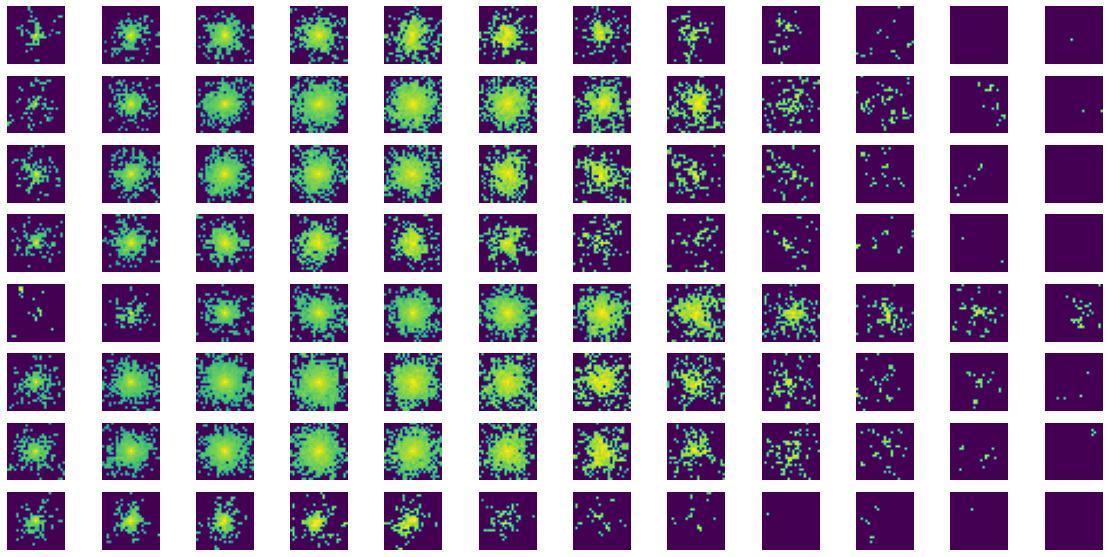

DataLogger - INFO - Debug of data_images features finished.
ModelsLogger - INFO - Logging level set on DEBUG.
ModelsLogger - INFO - Start debugging the generator model.
ModelsLogger - INFO - (None, 8, 8, 8, 3)
ModelsLogger - INFO - (None, 8, 8, 8, 1)
ModelsLogger - INFO - (None, 8, 8, 8, 2)
ModelsLogger - INFO - (None, 8, 15, 15, 64)
ModelsLogger - INFO - (None, 10, 20, 20, 32)
ModelsLogger - INFO - Shape of the generator output: (None, 12, 25, 25, 1)
ModelsLogger - INFO - Shape of generated images: (8, 12, 25, 25, 1)


1)	Primary particle=1	Initial energy =15.014694213867188	Generated energy =[0.00786271]

2)	Primary particle=0	Initial energy =21.77123260498047	Generated energy =[0.00796434]

3)	Primary particle=0	Initial energy =7.537017822265625	Generated energy =[0.00794294]

4)	Primary particle=1	Initial energy =18.243207931518555	Generated energy =[0.0079296]

5)	Primary particle=1	Initial energy =14.196324348449707	Generated energy =[0.00792079]

6)	Primary particle=1	Initial energy =3.067044258117676	Generated energy =[0.00789932]

7)	Primary particle=0	Initial energy =26.741907119750977	Generated energy =[0.00803167]

8)	Primary particle=1	Initial energy =11.475473403930664	Generated energy =[0.00796766]



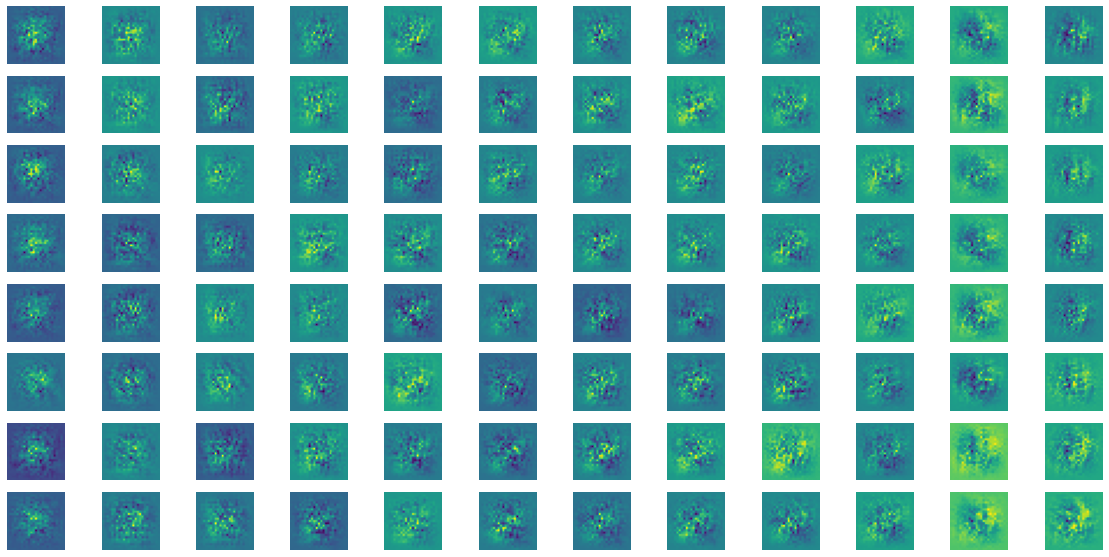

ModelsLogger - INFO - Debug of the generator model finished.
ModelsLogger - INFO - Logging level set on DEBUG.
ModelsLogger - INFO - Start debugging discriminator model.
ModelsLogger - INFO - (None, 12, 20, 20, 32)
ModelsLogger - INFO - Minibatch shape: (None, 6, 10, 10, 32)
ModelsLogger - INFO - (None, 4, 5, 5, 32)
ModelsLogger - INFO - (None, 2, 2, 2, 32)
ModelsLogger - INFO - 
Decision per raw:
 [[0.5152404 ]
 [0.546896  ]
 [0.53667384]
 [0.5060673 ]
 [0.52513   ]
 [0.5305733 ]
 [0.5344616 ]
 [0.50894755]]
ModelsLogger - INFO - Debug of the discriminator model finished.
ModelsLogger - INFO - (None, 8, 8, 8, 3)
ModelsLogger - INFO - (None, 8, 8, 8, 1)
ModelsLogger - INFO - (None, 8, 8, 8, 2)
ModelsLogger - INFO - (None, 8, 15, 15, 64)
ModelsLogger - INFO - (None, 10, 20, 20, 32)
ModelsLogger - INFO - Shape of the generator output: (None, 12, 25, 25, 1)
ModelsLogger - INFO - (None, 12, 20, 20, 32)
ModelsLogger - INFO - Minibatch shape: (None, 6, 10, 10, 32)
ModelsLogger - INFO - (None


Printing conditional GAN summary to file.


Plotting and saving conditional GAN scheme.



DEBUGLogger - INFO - The cGAN model has been plotted correctly.
DEBUGLogger - INFO - Testing the cGAN methods on noise and real samples.


Example 1	Primary particle = 1	Predicted particle = 0.5642393231391907
Initial energy = 2.7725396156311035	Generated energy = 0.007571985945105553	Predicted energy = 0.0	Decision = 0.5000958442687988

Example 2	Primary particle = 1	Predicted particle = 0.5642536878585815
Initial energy = 11.8472261428833	Generated energy = 0.007635982241481543	Predicted energy = 0.0	Decision = 0.4998982846736908

Example 3	Primary particle = 1	Predicted particle = 0.5642399191856384
Initial energy = 14.453033447265625	Generated energy = 0.007678059861063957	Predicted energy = 7.093245949363336e-05	Decision = 0.500024139881134

Example 4	Primary particle = 0	Predicted particle = 0.5642488598823547
Initial energy = 12.402597427368164	Generated energy = 0.007621690630912781	Predicted energy = 0.0	Decision = 0.5000249743461609

Example 5	Primary particle = 1	Predicted particle = 0.5642415881156921
Initial energy = 8.942233085632324	Generated energy = 0.0076217856258153915	Predicted energy = 0.0004334499535

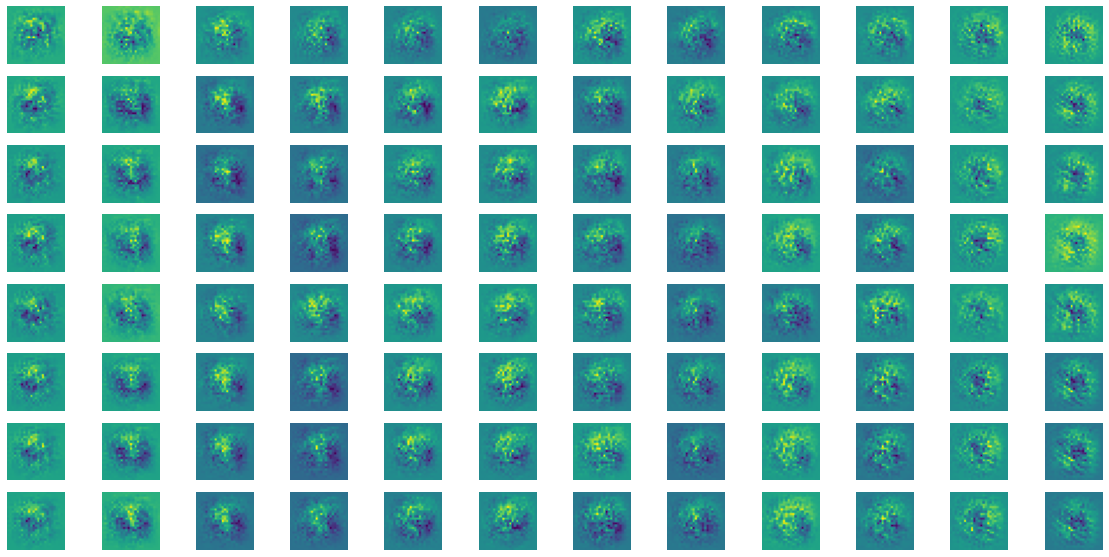

Restored from ./checkpoints/ckpt-14
Example 1
Primary particle = 0	Predicted particle = 0.6261554956436157
Initial energy = 2.7725396156311035	Generated energy = 2.2033274173736572	Predicted energy = 2.049030303955078	Decision = 0.08941804617643356


Example 2
Primary particle = 2	Predicted particle = 0.6847674250602722
Initial energy = 11.8472261428833	Generated energy = 13.162893295288086	Predicted energy = 13.397148132324219	Decision = 0.07028388977050781


Example 3
Primary particle = 2	Predicted particle = 0.6944172382354736
Initial energy = 14.453033447265625	Generated energy = 16.094839096069336	Predicted energy = 16.6241455078125	Decision = 0.07048138231039047


Example 4
Primary particle = 1	Predicted particle = 0.24083755910396576
Initial energy = 12.402597427368164	Generated energy = 12.80937385559082	Predicted energy = 12.257513046264648	Decision = 0.036143623292446136


Example 5
Primary particle = 0	Predicted particle = 0.652835488319397
Initial energy = 8.942233085632324

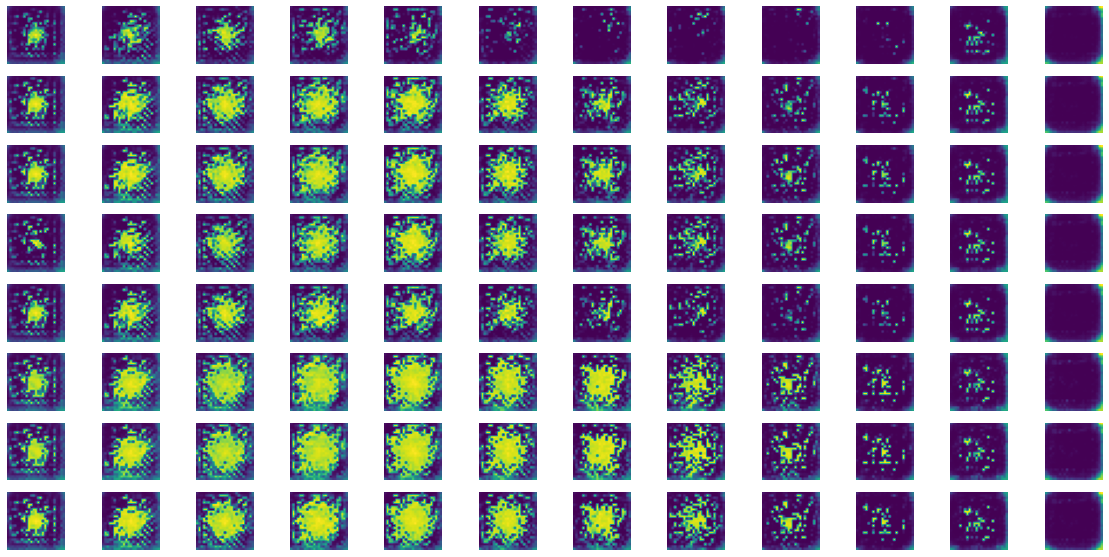

Example 1
Primary particle = 0	Predicted particle = 0.402204692363739
Initial energy = 3.91620125	Generated energy = 3.837343215942383	Predicted energy = 4.049749374389648	Decision = 0.8167538046836853


Example 2
Primary particle = 1	Predicted particle = 0.5387957692146301
Initial energy = 28.17697	Generated energy = 27.57717514038086	Predicted energy = 27.744049072265625	Decision = 0.9412930607795715


Example 3
Primary particle = 1	Predicted particle = 0.7363598942756653
Initial energy = 17.681412	Generated energy = 17.356582641601562	Predicted energy = 17.776884078979492	Decision = 0.7095460891723633


Example 4
Primary particle = 0	Predicted particle = 0.44342073798179626
Initial energy = 2.79506725	Generated energy = 2.7495291233062744	Predicted energy = 2.677407741546631	Decision = 0.6010277271270752


Example 5
Primary particle = 0	Predicted particle = 0.0388653501868248
Initial energy = 21.981388	Generated energy = 21.629356384277344	Predicted energy = 22.004743576049805	Decis

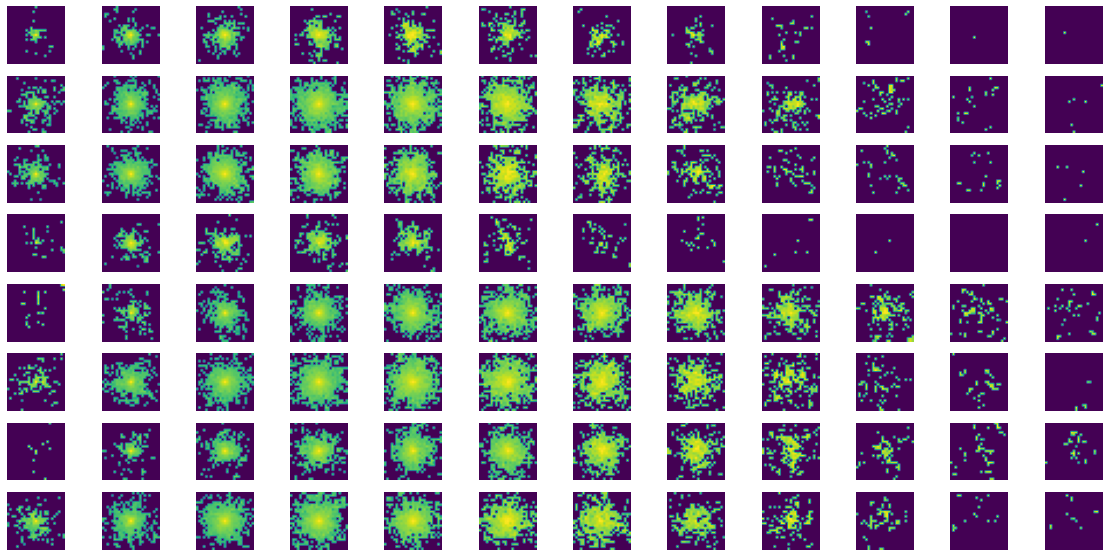

DEBUGLogger - INFO - Debug of the cGAN methods finished.
DEBUGLogger - INFO - The work is done.


In [9]:
debug(path_list, verbose=VERBOSE)
generator = make_generator_model()

discriminator = make_discriminator_model()

cond_gan = ConditionalGAN(generator, discriminator)
logger.info("The cGAN model has been built correctly.")

cond_gan.summary()
cond_gan.plot_model()
logger.info("The cGAN model has been plotted correctly.")

try:
    debug_cgan(cond_gan, path_list)
except Exception as error:
    print(error)

logger.info("The work is done.")
logger.handlers.clear()

 TRAIN
 =====

In [ ]:
"""Creation and training of the conditional GAN."""
if VERBOSE :
   logger.setLevel(logging.DEBUG)
   logger.info('Logging level set on DEBUG.')
else:
   logger.setLevel(logging.WARNING)
   logger.info('Logging level set on WARNING.')

logger.info("Start building operations.")
train_dataset = data_pull(path_list)

generator = make_generator_model()

discriminator = make_discriminator_model()

cond_gan = ConditionalGAN(generator, discriminator)
logger.info("The cGAN model has been built correctly.")

global_metrics_real_data()
history = cond_gan.train(train_dataset, epochs=70, batch=64, wake_up=70)
np.save(os.path.join("model_results","history.npy"), history)

plt.figure("Evolution of losses per epochs")
for key in history:
    plt.plot(history[key], label=key)
plt.legend()
plt.show()

logger.info("The cGAN model has been trained correctly.")

logger.info("The work is done.")
logger.handlers.clear()

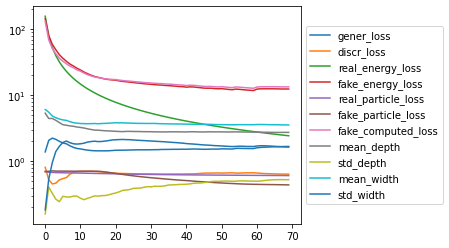

In [ ]:
hist = np.load(os.path.join("model_results","history.npy"), allow_pickle=True)
hist = hist.item() # necessary because numpy create a structured dictionary
fig = plt.figure("Evolution of losses per epochs")
ax = plt.subplot(111)
for key in hist:
    plt.plot(hist[key], label=key)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.show()


Push to GitHub
==============

In [ ]:
!git pull

In [ ]:
!git status

In [ ]:
!git config --global user.email "cafasso.dario@gmail.com"

In [ ]:
!git config --global user.email "d.passaro1@studenti.unipi.it"

In [ ]:
!git add ..
!git commit -m "push from colab"

In [ ]:
#Generate the <TOKEN> in Profile/Setting/Developer_setting/Personal_access_token
!git push https://Dario-Caf:<TOKEN>@github.com/Dario-Caf/EM-shower-simulator-with-NN.git

# Download in locale

In [ ]:
!zip -r /content/EM-shower-simulator-with-NN/EM_shower_simulator/checkpoints.zip /content/EM-shower-simulator-with-NN/EM_shower_simulator/checkpoints

from google.colab import files
files.download('/content/EM-shower-simulator-with-NN/EM_shower_simulator/checkpoints.zip')

  adding: content/EM-shower-simulator-with-NN/EM_shower_simulator/checkpoints/ (stored 0%)
  adding: content/EM-shower-simulator-with-NN/EM_shower_simulator/checkpoints/ckpt-13.index (deflated 76%)
  adding: content/EM-shower-simulator-with-NN/EM_shower_simulator/checkpoints/ckpt-10.index (deflated 76%)
  adding: content/EM-shower-simulator-with-NN/EM_shower_simulator/checkpoints/ckpt-11.data-00000-of-00001 (deflated 21%)
  adding: content/EM-shower-simulator-with-NN/EM_shower_simulator/checkpoints/ckpt-11.index (deflated 76%)
  adding: content/EM-shower-simulator-with-NN/EM_shower_simulator/checkpoints/checkpoint (deflated 71%)
  adding: content/EM-shower-simulator-with-NN/EM_shower_simulator/checkpoints/ckpt-13.data-00000-of-00001 (deflated 21%)
  adding: content/EM-shower-simulator-with-NN/EM_shower_simulator/checkpoints/ckpt-10.data-00000-of-00001 (deflated 21%)
  adding: content/EM-shower-simulator-with-NN/EM_shower_simulator/checkpoints/ckpt-14.index (deflated 76%)
  adding: cont

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>